In [53]:
from keras.models import load_model
from nltk.probability import FreqDist
from operator import itemgetter 
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle

basedir ='/content/drive/MyDrive/MB/'

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# Loading all descriptions
train_descriptions = pickle.load(open("/content/drive/MyDrive/MB/train_descriptions.pkl", "rb"))
test_descriptions = pickle.load(open("/content/drive/MyDrive/MB/test_descriptions.pkl", "rb"))

def clean_descriptions(descriptions):
  def clean_image_descriptions(img_descriptions):
    words_to_filter = ['startseq', 'endseq']
    
    return [' '.join([token for token in desc.split() if token not in words_to_filter]) for desc in img_descriptions]
  return {k: clean_image_descriptions(v) for k, v in descriptions.items()}

all_descriptions = {**clean_descriptions(train_descriptions), **clean_descriptions(test_descriptions)}

train_predictions = pickle.load(open("/content/drive/MyDrive/MB/train_predictions.pkl", "rb"))
test_predictions = pickle.load(open("/content/drive/MyDrive/MB/test_predictions.pkl", "rb"))
all_predictions = {**train_predictions, **test_predictions}

train_keys = list(train_predictions.keys())
test_keys = list(test_predictions.keys())

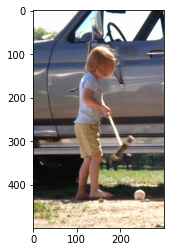

Model na danych oczyszczonych:
Greedy: boy wearing white shirt walking along path
Refs: 
 little baby play croquet
little girl play croquet next truck
child playing croquette truck
kid front car put ball
little boy playing croquet hammer ball beside car


In [56]:
directory_path = '/content/drive/My Drive/Flickr8k_Dataset/Flicker8k_Dataset/'

z = 1

pic = list(train_predictions.keys())[z]
img=plt.imread(directory_path+pic)
plt.imshow(img)
plt.show()

print("Model na danych oczyszczonych:")
print("Greedy:", train_predictions[pic])
print("Refs: \n", '\n'.join(all_descriptions[pic.split('.')[0]]))

In [57]:
from collections.abc import Iterable

#BOW dla pojedynczego obrazka treningowego, jest to worek słów
def bow_words(data):
  word_counts = []
  def process_sentence(sentence):
    for word in sentence.split():
        if word not in word_counts:
          word_counts.append(word)

  if isinstance(data, str):
    process_sentence(data)
  elif isinstance(data, Iterable):
    for sentence in data:
      process_sentence(sentence)
  return word_counts

In [58]:
all_bows = {}
for img_id, img_descriptions in all_descriptions.items():
  all_bows[img_id] = bow_words(img_descriptions)

In [59]:
def calc_score(bow, reference_bow):
  count = 0
  for word in bow:
    if word in reference_bow:
      count += 1
  return count/len(bow)

In [60]:
def percentage_bow(img_id, raw = False): #wartość dla konkretnego obrazka, wartości predykcji
  actual_bow = bow_words(all_descriptions[img_id.split('.')[0]])
  predicted_bow = bow_words(all_predictions[img_id])
  return calc_score(predicted_bow, actual_bow)

In [61]:
def best_image_bow(img_id, reference_ids):
  predicted_bow = bow_words(all_predictions[img_id])
  scores = []
  for reference_id in reference_ids:
    reference_bow = all_bows[reference_id.split('.')[0]]
    score = calc_score(predicted_bow, reference_bow)
    scores.append((reference_id, score))
  
  scores.sort(key=itemgetter(1), reverse=True)
  max_img_id, max_score = scores[0]
  return scores, max_score, max_img_id # wartosci predykcji i maks wartosc i id max wartości

In [62]:
#dla zbioru treningowego
def bow_max_index_probability(reference_ids):
  good_images_ids = []
  good_bows = {
      'predicted': [],
      'actual': []
  }
  wrong_bows = {
      'predicted': [],
      'actual': [],
      'best': []
  }
  
  for img_id in reference_ids:

    scores, max_score, max_img_id = best_image_bow(img_id, reference_ids) 
    img_score = dict(scores)[img_id] # wyszukujemy wynik dla danego obrazka

    good_scores = sorted(scores, reverse=True)[-math.ceil(len(scores)*0.3):] # bierzemy ostatnie 30 % wyników
    if img_score > 0.5 and img_score >= good_scores[0][1]: # sprawdzamy czy bow dla obrazka jest większe bądź równe najmniejszej wartości z 30% wyników
      good_images_ids.append(img_id)
      good_bows['actual'] += all_bows[img_id.split('.')[0]]
      good_bows['predicted'] += bow_words(all_predictions[img_id])
    else:
      wrong_bows['best'] += all_bows[max_img_id.split('.')[0]]
      wrong_bows['actual'] += all_bows[img_id.split('.')[0]]
      wrong_bows['predicted'] += bow_words(all_predictions[img_id])
      
    good_predictions_percentage = len(good_images_ids)/len(reference_ids)
  return good_bows, wrong_bows, good_images_ids

In [63]:
# good_bows, wrong_bows, good_predictions_percentage = bow_max_index_probability(train_keys)
good_bows, wrong_bows, good_images_ids = bow_max_index_probability(train_keys)

zdjęcie: 


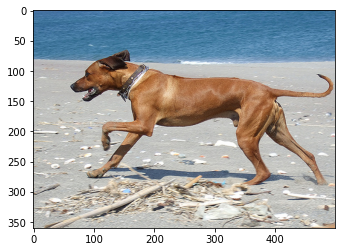

oczyszczone opisy:  ['brown dog running along beach', 'brown dog wearing black collar running across beach', 'dog walk sand near water', 'brown dog running beach', 'large brown dog running beach ocean']
przewidziany opis:  brown dog running water
wynik bow dla danego obrazu:  1.0

najlepszy wynik bow:  1.0
zdania, do których najlepiej dopasowano:  ['black dog running white dog snow', 'black dog chasing brown dog snow', 'two dog chase across snowy ground', 'two dog play together snow', 'two dog running low lying body water']
zdjęcie najlepszego dopasowania: 


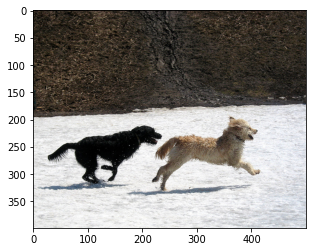

In [64]:
### przykłady:
idx = 4
key = '488416045_1c6d903fe0.jpg' # train_keys[idx]

scores, max_score, max_img_id = best_image_bow(key, train_keys)

print('zdjęcie: ')
img = plt.imread(directory_path+key)
plt.imshow(img)
plt.show()

print('oczyszczone opisy: ', all_descriptions[key.split('.')[0]])
print('przewidziany opis: ', all_predictions[key])
print('wynik bow dla danego obrazu: ', dict(scores)[key])
print()
print('najlepszy wynik bow: ', max_score)
print('zdania, do których najlepiej dopasowano: ', all_descriptions[max_img_id.split('.')[0]])

print('zdjęcie najlepszego dopasowania: ')
img = plt.imread(directory_path+max_img_id)
plt.imshow(img)
plt.show()

In [65]:
good_predictions_percentage = len(good_images_ids)/len(train_keys)
print('Procent prawidłowych dopasowań (wynik > 0.5, należy do najlepszych 30%):', good_predictions_percentage)

Procent prawidłowych dopasowań (wynik > 0.5, należy do najlepszych 30%): 0.35983333333333334


In [66]:
def plotFreqDist(bow, title):
  fdist = FreqDist(bow)
  print(title)
  fdist.plot(30,cumulative=False)
  plt.show()

zdania przewidziane poprawnie


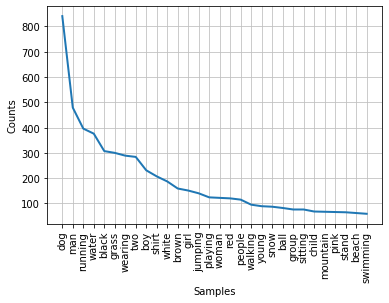

worki dla zdań przewidzianych poprawnie


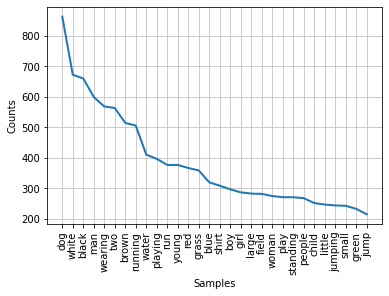

In [67]:
#zdania przewidziane poprawnie
plotFreqDist(good_bows['predicted'], 'zdania przewidziane poprawnie')

#worki dla zdań przewidzianych poprawnie
plotFreqDist(good_bows['actual'], 'worki dla zdań przewidzianych poprawnie')

zdania przewidziane źle


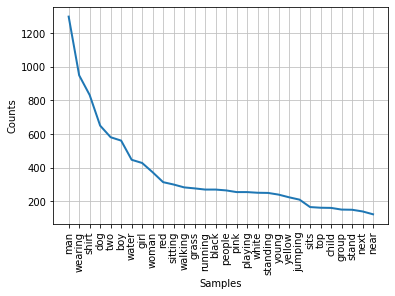

worki dla zdań przewidzianych źle, najlepsze


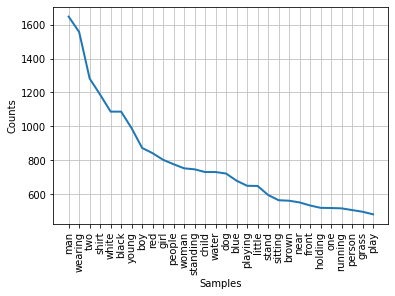

worki dla zdań przewidzianych źle, uczące


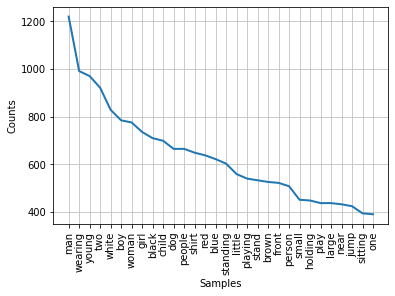

In [68]:
#zdania przewidziane źle
plotFreqDist(wrong_bows['predicted'], 'zdania przewidziane źle')

#worki dla zdań przewidzianych źle, najlepsze
plotFreqDist(wrong_bows['best'], 'worki dla zdań przewidzianych źle, najlepsze')

#worki dla zdań przewidzianych źle, uczące
plotFreqDist(wrong_bows['actual'], 'worki dla zdań przewidzianych źle, uczące')

In [69]:
mean_percentage_bow_train = np.mean([percentage_bow(img_id) for img_id in train_keys])
print('Średnia wartość BOW dla zbioru treningowego', mean_percentage_bow_train)

Średnia wartość BOW dla zbioru treningowego 0.46649648268398264


In [70]:
good_bows_test, wrong_bows_test, good_images_ids_test = bow_max_index_probability(test_keys)

In [71]:
good_predictions_percentage_test = len(good_images_ids_test)/len(test_keys)
print('Procent prawidłowych dopasowań zbioru testowego (wynik > 0.5, należy do 30%):', good_predictions_percentage_test)

Procent prawidłowych dopasowań zbioru testowego (wynik > 0.5, należy do 30%): 0.259


zdania przewidziane poprawnie


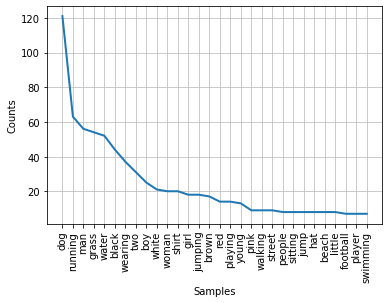

worki dla zdań przewidzianych poprawnie


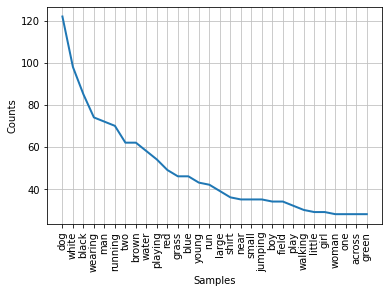

In [72]:
#zdania przewidziane poprawnie
plotFreqDist(good_bows_test['predicted'], 'zdania przewidziane poprawnie')

#worki dla zdań przewidzianych poprawnie
plotFreqDist(good_bows_test['actual'], 'worki dla zdań przewidzianych poprawnie')

zdania przewidziane źle


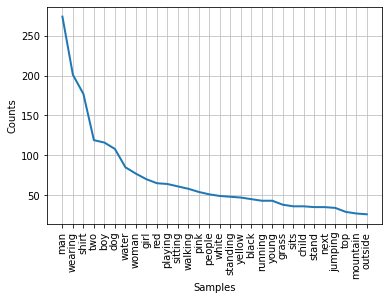

worki dla zdań przewidzianych źle, najlepsze


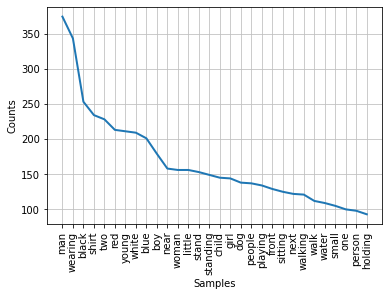

worki dla zdań przewidzianych źle, uczące


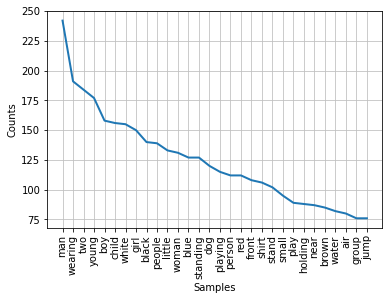

In [73]:
#zdania przewidziane źle
plotFreqDist(wrong_bows_test['predicted'], 'zdania przewidziane źle')

#worki dla zdań przewidzianych źle, najlepsze
plotFreqDist(wrong_bows_test['best'], 'worki dla zdań przewidzianych źle, najlepsze')

#worki dla zdań przewidzianych źle, uczące
plotFreqDist(wrong_bows_test['actual'], 'worki dla zdań przewidzianych źle, uczące')

In [74]:
mean_percentage_bow_test = np.mean([percentage_bow(img_id) for img_id in test_keys])
print('Średnia wartość BOW dla zbioru testowego', mean_percentage_bow_test)

Średnia wartość BOW dla zbioru testowego 0.3952051587301587


In [75]:
from nltk.translate.bleu_score import corpus_bleu
def evaluate_bleu(image_ids):
  actual, predicted = list(), list()

	# step over the whole set
  for img_id in image_ids:
    # store actual and predicted
    references = [d.split() for d in all_descriptions[img_id.split('.')[0]]]
    actual.append(references)
    predicted.append(all_predictions[img_id].split())
	# calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [76]:
evaluate_bleu(train_keys)

BLEU-1: 0.407606
BLEU-2: 0.240751
BLEU-3: 0.168412
BLEU-4: 0.077612


In [77]:
evaluate_bleu(test_keys)

BLEU-1: 0.345490
BLEU-2: 0.180342
BLEU-3: 0.112954
BLEU-4: 0.041481
